In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', 40)
!date

Tue Mar 10 09:36:03 PDT 2020


# 2010 census demo data. urban vs rural areas: looking for the downward bias in DP counts ala Akee's findings

Akee's talk here: https://vimeo.com/380264104

In [2]:
##Encoding of the AIANHH var:
#0001–4999 Federally recognized American Indian reservation and/or off-reservation trust land
#5000–5499 Hawaiian home land 5500–5999 Oklahoma tribal statistical area
#5500–5999 Oklahoma tribal statistical area
#6000–7999 Alaska Native village statistical area
#8000–8999 Tribal designated statistical area
#9000–9499 State-recognized American Indian reservation
#9500–9998 State designated tribal statistical area 

In [3]:
## Encoding of race vars
# White alone P0030002
# Black or African American alone P0030003
# American Indian and Alaska Native alone P0030004
# Asian alone P0030005
# Native Hawaiian and Other Pacific Islander alone P0030006 
# Some Other Race alone P0030007 
# Two or More Races P0030008 

In [4]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

race_cols = ['P0030001','P0030002','P0030003','P0030004','P0030005','P0030006','P0030007','P0030008'] # race vars
keep_cols = location_cols + race_cols

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','UA','UR')):
        return True
    else:
        return (x in keep_cols)

In [5]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)
df_dp.backup = df_dp.copy(deep=True)

<string>:2: DtypeWarning: Columns (28,32,33,47,49,50) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 6min 18s, sys: 21 s, total: 6min 39s
Wall time: 6min 46s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [6]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[-9:] = df_dp.columns[-9:] #coded vars are capitalized
# dta_columns #check contents

In [7]:
%%time

# r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
#                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

# df_sf = pd.DataFrame()
# for t in r:
#     print('.', flush=True, end=' ')
#     df_sf = df_sf.append(t[t.block != ''])
# df_sf.shape

# #saved AIAN-relevant vars here; loads faster than the .dta
df_sf = pd.read_csv('/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv')
df_sf.backup = df_sf.copy(deep=True)

<string>:2: DtypeWarning: Columns (7,10,11) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 12.9 s, sys: 3.95 s, total: 16.8 s
Wall time: 17.6 s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [8]:
# df_sf.to_csv(r'/home/j/temp/beatrixh/2020_census/all50states_all_races_02_27_2020.csv', index = None, header=True)

In [9]:
df_sf.columns = [x.upper() for x in df_sf.columns]
df_sf.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH', 'AIANHHFP',
       'AIANHHCC', 'AITSCE', 'AITS', 'AITSCC', 'TTRACT', 'UA', 'UASC',
       'UATYPE', 'UR', 'AIANHHNS', 'AITSNS', 'AIANHHSC', 'P0010001',
       'P0030001', 'P0030002', 'P0030003', 'P0030004', 'P0030005', 'P0030006',
       'P0030007', 'P0030008'],
      dtype='object')

In [10]:
# df_sf = df_sf.drop('UASC', axis=1)
df_dp = df_dp.drop('UASC', axis=1) #this is just NANs

In [11]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH']

In [12]:
block_level = pd.merge(df_sf[df_sf.BLOCK.notnull()],
                       df_dp[df_dp.BLOCK.notnull()][location_cols + race_cols + ['P0010001']],
                       left_on=location_cols,
                       right_on=location_cols,
                       suffixes=('_SF', '_DP'))

In [13]:
# make sure no one is double counted or lost; us pop should be around 308.7 mil (accoding to 2010 census report)
print(f'total population sum: {block_level.P0010001_SF.sum()}')
print(f'total population DP sum: {block_level.P0010001_DP.sum()}')
print(f'total population sum: {block_level.P0030001_SF.sum()}')

total population sum: 308143815
total population DP sum: 308143815
total population sum: 308143815


In [14]:
#that's 7e5 missing. by race is it even?
print(f'total white alone sum (223.6 mil?): {block_level.P0030002_SF.sum()}')
print(f'total black alone sum (42.02 mil?): {block_level.P0030003_SF.sum()}')
print(f'total asian alone sum (17.3 mil?): {block_level.P0030005_SF.sum()}')
print(f'native hawaiian and other pacific islander: {block_level.P0030006_SF.sum()}')
print(f'pct total of expected: {block_level.P0010001_SF.sum()/308.7e6}')
print(f'pct white of expected: {block_level.P0030002_SF.sum()/223.6e6}')
print(f'pct black of expected: {block_level.P0030003_SF.sum()/38_929_319}')
print(f'pct asian of expected: {block_level.P0030005_SF.sum()/14_674_252}')
print(f'pct native hawaiian and other pacific islander of expected: {block_level.P0030006_SF.sum()/540_013}')
print(f'pct AIAN of expected: {block_level.P0030004_SF.sum()/2_932_248}')
print(f'pct "some other race" of expected: {block_level.P0030007_SF.sum()/19.1e6}')

total white alone sum (223.6 mil?): 223321794
total black alone sum (42.02 mil?): 38624194
total asian alone sum (17.3 mil?): 14653196
native hawaiian and other pacific islander: 539711
pct total of expected: 0.9981982993197279
pct white of expected: 0.9987557871198569
pct black of expected: 0.9921620771223869
pct asian of expected: 0.9985651057375872
pct native hawaiian and other pacific islander of expected: 0.9994407542040654
pct AIAN of expected: 0.9992909876654362
pct "some other race" of expected: 0.9991096335078534


In [15]:
# oh oops. i was missing DC, which had pop of 601_723
print(f'total population sum incl DC should be 308,745,538: {block_level.P0030001_SF.sum()+601_723}')

total population sum incl DC should be 308,745,538: 308745538


In [16]:
# first: by county, urban v rural aian
rural_block_level = block_level[block_level.UR=='R']
urban_block_level = block_level[block_level.UR=='U']

In [17]:
race_vars = [str(i) + '_SF' for i in race_cols + ['P0010001']] + [str(i) + '_DP' for i in race_cols + ['P0010001']]

In [18]:
rural_county_level = rural_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())
urban_county_level = urban_block_level.groupby(['STATE','COUNTY'])[race_vars].apply(lambda x : x.astype(int).sum())

# look at change at reservation level (same as akee)

In [19]:
# things to check:
# can you make it a function of total population... ? start with that. then.. what other things do you think might be predictors?
# maybe percent of total population?
# you could also checkout pct diff instead of abs diff

In [20]:
block_level_aiannh = block_level[block_level.AIANHH!=9999]

In [21]:
res_level_aian = block_level_aiannh.groupby(['AIANHH'])[race_vars].apply(lambda x : x.astype(int).sum())

In [22]:
# add var to predict
res_level_aian['count_diff'] = res_level_aian['P0030004_DP'] - res_level_aian['P0030004_SF']
res_level_aian['count_prop_diff'] = res_level_aian['P0030004_DP'] / res_level_aian['P0030004_SF']

NameError: name 'lim' is not defined

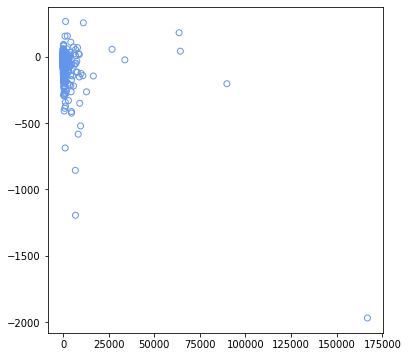

In [23]:
# checkout change on res
x = res_level_aian[["P0030004_SF"]]
y = res_level_aian[["count_diff"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
# ax.set_aspect('equal', adjustable='box')

# xleft, xright = ax.get_xlim()
# ybottom, ytop = ax.get_ylim()
# lim = max(xright,ytop)
ax.plot([0,lim],[0,0], 'red', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('On-reservation AIAN population count change as function of AIAN pop count')

plt.show()

In [ ]:
# checkout change on res
x = res_level_aian[["P0010001_SF"]]
y = res_level_aian[["count_diff"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
# ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('On-reservation AIAN population count change as function of total pop count')

plt.show()

In [ ]:
from sklearn import linear_model

In [171]:
#create selection vector to grab 80% of the data
select = np.random.binomial(1,p=0.8,size=res_level_aian.shape[0])
select = select.astype(bool)

In [178]:
#run regression
X = res_level_aian[['P0010001_SF']]
y = res_level_aian[['count_diff']]
lm = linear_model.LinearRegression()
model = lm.fit(X[select],y[select])

In [179]:
predictions = lm.predict(X)

In [197]:
# this was a terrible predictor. need to comb codebook for better vars. things to check
b = lm.intercept_[0]
m = lm.coef_[0]
print([m,b])

[array([-0.00010413]), -49.58446267843121]


In [ ]:
# vars to try
# AIANHH, geographic location, % urban? if crosses state lines? % of other races? 

In [196]:
y = []
for x in range(1000):
    fx = b+m*x
    y = y + [fx]

In [ ]:
# plot preds
x = res_level_aian[["P0010001_SF"]]
y = res_level_aian[["count_diff"]] 

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot()
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
# ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)

# plt.xlabel('AIAN alone counts on reservations in 2010 census with swapping')
# plt.ylabel('AIAN alone counts on reservations in 2010 census with DP')
plt.title('On-reservation AIAN population count change as function of total pop count')

plt.show()